In [14]:
import numpy as np
import matplotlib.pyplot as plt
from grid import create_grid
from skimage.morphology import medial_axis
from skimage.util import invert
from planning_medial_axis import a_star
%matplotlib inline 

In [15]:
plt.rcParams['figure.figsize'] = 12, 12

In [3]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


In [4]:
start_ne = (25,  100)
goal_ne = (650, 500)

In [5]:
# Static drone altitude (meters)
drone_altitude = 5
safety_distance = 2

In [6]:
grid = create_grid(data, drone_altitude, safety_distance)
skeleton = medial_axis(invert(grid))


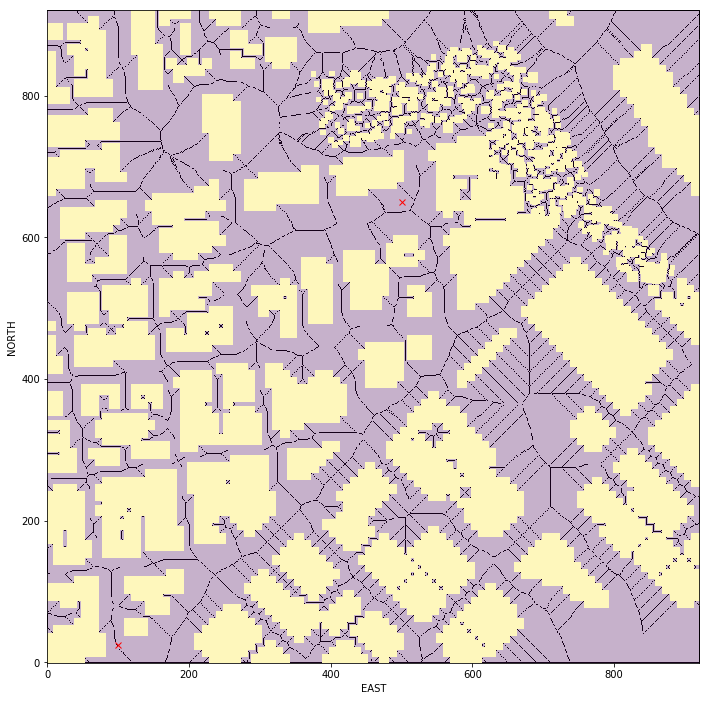

In [7]:
# equivalent to
# plt.imshow(np.flip(grid, 0))

plt.imshow(grid, origin='lower')
plt.imshow(skeleton, cmap='Greys', origin='lower', alpha=0.7)
    
plt.plot(start_ne[1], start_ne[0], 'rx')
plt.plot(goal_ne[1], goal_ne[0], 'rx')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

In [11]:
def find_start_goal(skel, start, goal):
    skel_cells = np.transpose(skel.nonzero())
    start_min_dist = np.linalg.norm(np.array(start) - np.array(skel_cells), axis=1).argmin()
    near_start = skel_cells[start_min_dist]
    goal_min_dist = np.linalg.norm(np.array(goal) - np.array(skel_cells), axis=1).argmin()
    near_goal = skel_cells[goal_min_dist]
    
    return near_start, near_goal

skel_start, skel_goal = find_start_goal(skeleton, start_ne, goal_ne)

print(start_ne, goal_ne)
print(skel_start, skel_goal)


(25, 100) (650, 500)
[24 99] [636 501]


In [12]:
def heuristic_func(position, goal_position):
    return np.sqrt((position[0] - goal_position[0])**2 + (position[1] - goal_position[1])**2)

In [16]:
# Run A* on the skeleton
path, cost = a_star(invert(skeleton).astype(np.int), heuristic_func, tuple(skel_start), tuple(skel_goal))
print("Path length = {0}, path cost = {1}".format(len(path), cost))

Found a path.
Path length = 810, path cost = 985.869191133316


In [17]:
# Compare to regular A* on the grid
path2, cost2 = a_star(grid, heuristic_func, start_ne, goal_ne)
print("Path length = {0}, path cost = {1}".format(len(path2), cost2))

Found a path.
Path length = 681, path cost = 832.8448045156754


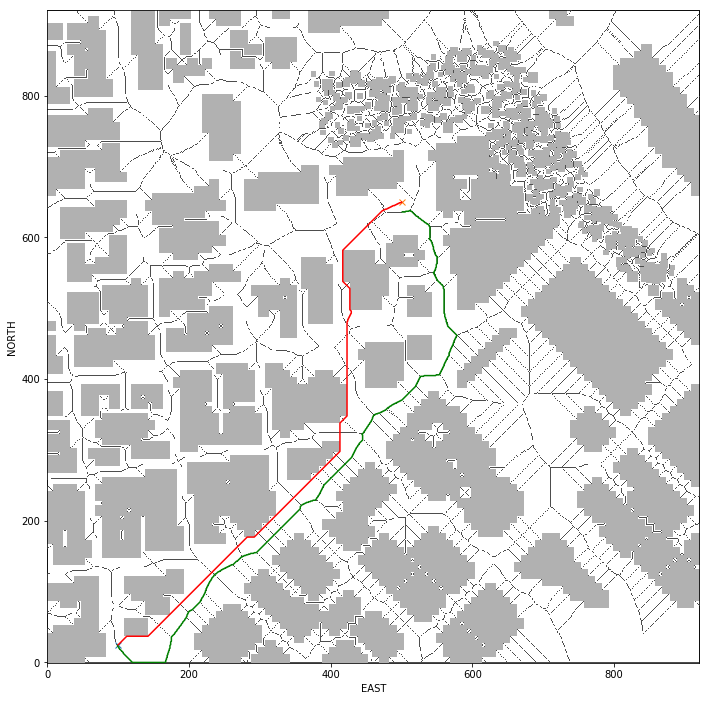

In [18]:
plt.imshow(grid, cmap='Greys', origin='lower')
plt.imshow(skeleton, cmap='Greys', origin='lower', alpha=0.7)
# For the purposes of the visual the east coordinate lay along
# the x-axis and the north coordinates long the y-axis.
plt.plot(start_ne[1], start_ne[0], 'x')
plt.plot(goal_ne[1], goal_ne[0], 'x')

pp = np.array(path)
plt.plot(pp[:, 1], pp[:, 0], 'g')
pp2 = np.array(path2)
plt.plot(pp2[:, 1], pp2[:, 0], 'r')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

## Path Pruning

In [19]:
def point(p):
    return np.array([p[0], p[1], 1.]).reshape(1, -1)

def collinearity_check(p1, p2, p3, epsilon=1e-6):   
    m = np.concatenate((p1, p2, p3), 0)
    det = np.linalg.det(m)
    return abs(det) < epsilon

In [20]:
# We're using collinearity here, but you could use Bresenham as well!
def prune_path(path):
    pruned_path = [p for p in path]
    # TODO: prune the path!
    
    i = 0
    while i < len(pruned_path) - 2:
        p1 = point(pruned_path[i])
        p2 = point(pruned_path[i+1])
        p3 = point(pruned_path[i+2])
        
        # If the 3 points are in a line remove
        # the 2nd point.
        # The 3rd point now becomes and 2nd point
        # and the check is redone with a new third point
        # on the next iteration.
        if collinearity_check(p1, p2, p3):
            # Something subtle here but we can mutate
            # `pruned_path` freely because the length
            # of the list is check on every iteration.
            pruned_path.remove(pruned_path[i+1])
        else:
            i += 1
    return pruned_path

In [21]:
pruned_path = prune_path(path)
print(len(pruned_path))

366


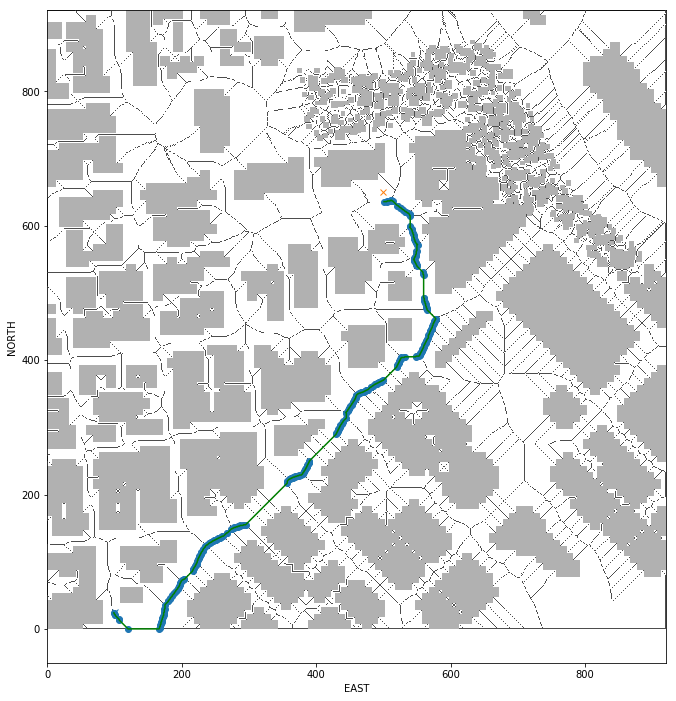

In [24]:
plt.imshow(grid, cmap='Greys', origin='lower')
plt.imshow(skeleton, cmap='Greys', origin='lower', alpha=0.7)
# For the purposes of the visual the east coordinate lay along
# the x-axis and the north coordinates long the y-axis.
plt.plot(start_ne[1], start_ne[0], 'x')
plt.plot(goal_ne[1], goal_ne[0], 'x')

pp = np.array(pruned_path)
plt.plot(pp[:, 1], pp[:, 0], 'g')
plt.scatter(pp[:, 1], pp[:, 0])


plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()